In [116]:
import pandas as pd
import numpy as np
import cv2
import re
import seaborn as sns
import string
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
from PIL import Image
style.use("ggplot")
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix , ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import plotly

In [117]:
df = pd.read_excel("D:\\Data Analyst Laptop\\Data Science practice after graduation\\Pfizer twitter\\Vaccination sentiment.xlsx")
df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1.340539e+18,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1.338159e+18,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1.337858e+18,eliðŸ‡±ðŸ‡¹ðŸ‡ªðŸ‡ºðŸ‘Œ,Your Bed,"heil, hydra ðŸ–â˜º",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1.337856e+18,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1.337854e+18,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [118]:
print(df.columns.tolist())

['id', 'user_name', 'user_location', 'user_description', 'user_created', 'user_followers', 'user_friends', 'user_favourites', 'user_verified', 'date', 'text', 'hashtags', 'source', 'retweets', 'favorites', 'is_retweet']


In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11020 entries, 0 to 11019
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                11020 non-null  float64       
 1   user_name         11018 non-null  object        
 2   user_location     8750 non-null   object        
 3   user_description  10339 non-null  object        
 4   user_created      11020 non-null  datetime64[ns]
 5   user_followers    11020 non-null  int64         
 6   user_friends      11020 non-null  int64         
 7   user_favourites   11020 non-null  int64         
 8   user_verified     11020 non-null  bool          
 9   date              11020 non-null  datetime64[ns]
 10  text              11020 non-null  object        
 11  hashtags          8438 non-null   object        
 12  source            11019 non-null  object        
 13  retweets          11020 non-null  int64         
 14  favorites         1102

In [120]:
print(df.isnull().sum())

id                     0
user_name              2
user_location       2270
user_description     681
user_created           0
user_followers         0
user_friends           0
user_favourites        0
user_verified          0
date                   0
text                   0
hashtags            2582
source                 1
retweets               0
favorites              0
is_retweet             0
dtype: int64


In [121]:
df_text = df.drop(['id', 'user_name', 'user_location', 'user_description', 'user_created', 'user_followers', 'user_friends', 'user_favourites', 'user_verified', 'date', 'hashtags', 'source', 'retweets', 'favorites', 'is_retweet'],axis=1)
df_text

,text
0,Same folks said daikon paste could treat a cyt...
1,While the world has been on the wrong side of ...
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...
3,"Facts are immutable, Senator, even when you're..."
4,Explain to me again why we need a vaccine @Bor...
...,...
11015,"The number of Covid-19 cases today, 17 Novembe..."
11016,First dose âœ…\n#PfizerBioNTech
11017,"The number of Covid-19 cases today, 16 Novembe..."
11018,#PfizerBioNTech has developed new pill #Paxlov...


In [122]:
print(df_text['text'].iloc[0],"\n")
print(df_text['text'].iloc[1],"\n")
print(df_text['text'].iloc[2],"\n")
print(df_text['text'].iloc[3],"\n")

Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF 

While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've evâ€¦ https://t.co/dlCHrZjkhm 

#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 yearsâ€¦ https://t.co/ieYlCKBr8P 

Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born iâ€¦ https://t.co/jqgV18kch4 



In [123]:
from nltk.stem import PorterStemmer

In [124]:
from nltk.stem import WordNetLemmatizer


In [125]:
df.source

0        Twitter for Android
1            Twitter Web App
2        Twitter for Android
3            Twitter Web App
4         Twitter for iPhone
                ...         
11015        Twitter Web App
11016    Twitter for Android
11017        Twitter Web App
11018        Twitter Web App
11019        Twitter Web App
Name: source, Length: 11020, dtype: object

In [126]:
df_text.text

0        Same folks said daikon paste could treat a cyt...
1        While the world has been on the wrong side of ...
2        #coronavirus #SputnikV #AstraZeneca #PfizerBio...
3        Facts are immutable, Senator, even when you're...
4        Explain to me again why we need a vaccine @Bor...
                               ...                        
11015    The number of Covid-19 cases today, 17 Novembe...
11016                      First dose âœ…\n#PfizerBioNTech
11017    The number of Covid-19 cases today, 16 Novembe...
11018    #PfizerBioNTech has developed new pill #Paxlov...
11019    The number of Covid-19 cases today, 15 Novembe...
Name: text, Length: 11020, dtype: object

In [127]:
def data_process(content):
    content = content.lower()
    content = re.sub(r"https\S+|wwww\S+",'',content,flags=re.MULTILINE)
    content = re.sub(r'\@w+|\#','',content)
    content = re.sub(r'[^\w\s]','',content)
    content_token = word_tokenize(content)
    filter_content = [w for w in content_token if not w in stop_words]
    return " ".join(filter_content)
    

In [128]:
df_text = df_text['text'].apply(data_process)

In [129]:
df_text

0        folks said daikon paste could treat cytokine s...
1        world wrong side history year hopefully bigges...
2        coronavirus sputnikv astrazeneca pfizerbiontec...
3        facts immutable senator even youre ethically s...
4        explain need vaccine borisjohnson matthancock ...
                               ...                        
11015    number covid19 cases today 17 november 2021 re...
11016                         first dose âœ pfizerbiontech
11017    number covid19 cases today 16 november 2021 re...
11018    pfizerbiontech developed new pill paxlovid inc...
11019    number covid19 cases today 15 november 2021 re...
Name: text, Length: 11020, dtype: object

In [130]:
df_text.head()

0    folks said daikon paste could treat cytokine s...
1    world wrong side history year hopefully bigges...
2    coronavirus sputnikv astrazeneca pfizerbiontec...
3    facts immutable senator even youre ethically s...
4    explain need vaccine borisjohnson matthancock ...
Name: text, dtype: object

In [131]:
print(df_text[0])
print(df_text[1])
print(df_text[2])


folks said daikon paste could treat cytokine storm pfizerbiontech
world wrong side history year hopefully biggest vaccination effort weve evâ
coronavirus sputnikv astrazeneca pfizerbiontech moderna covid_19 russian vaccine created last 24 yearsâ


In [132]:
df_text = pd.DataFrame(df_text)
df_text

,text
0,folks said daikon paste could treat cytokine s...
1,world wrong side history year hopefully bigges...
2,coronavirus sputnikv astrazeneca pfizerbiontec...
3,facts immutable senator even youre ethically s...
4,explain need vaccine borisjohnson matthancock ...
...,...
11015,number covid19 cases today 17 november 2021 re...
11016,first dose âœ pfizerbiontech
11017,number covid19 cases today 16 november 2021 re...
11018,pfizerbiontech developed new pill paxlovid inc...


In [133]:
df_text = df_text.drop_duplicates('text')
df_text

,text
0,folks said daikon paste could treat cytokine s...
1,world wrong side history year hopefully bigges...
2,coronavirus sputnikv astrazeneca pfizerbiontec...
3,facts immutable senator even youre ethically s...
4,explain need vaccine borisjohnson matthancock ...
...,...
11014,ruvanw gmalavige chandi2012 already 3rd pfizer...
11015,number covid19 cases today 17 november 2021 re...
11017,number covid19 cases today 16 november 2021 re...
11018,pfizerbiontech developed new pill paxlovid inc...


In [134]:
stemmer= PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

In [135]:
df_text['text'] = df_text['text'].apply(lambda x : stemming(x))

C:\Users\dell-pc\AppData\Local\Temp/ipykernel_8084/1641262578.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text['text'] = df_text['text'].apply(lambda x : stemming(x))


In [136]:
df_text.head()

,text
0,folks said daikon paste could treat cytokine s...
1,world wrong side history year hopefully bigges...
2,coronavirus sputnikv astrazeneca pfizerbiontec...
3,facts immutable senator even youre ethically s...
4,explain need vaccine borisjohnson matthancock ...


In [137]:
df_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10592 entries, 0 to 11019
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10592 non-null  object
dtypes: object(1)
memory usage: 165.5+ KB


In [138]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

In [139]:
df_text['Polarity']=df_text['text'].apply(polarity)

C:\Users\dell-pc\AppData\Local\Temp/ipykernel_8084/1273599003.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text['Polarity']=df_text['text'].apply(polarity)


In [140]:
df_text.head()

,text,Polarity
0,folks said daikon paste could treat cytokine s...,0.0
1,world wrong side history year hopefully bigges...,-0.5
2,coronavirus sputnikv astrazeneca pfizerbiontec...,0.0
3,facts immutable senator even youre ethically s...,0.1
4,explain need vaccine borisjohnson matthancock ...,0.0


In [141]:
def sentiment(label):
    if label <0:
        return "Negative"
    elif label ==0:
        return "Neutral"
    elif label >0:
        return "Positive"

In [142]:
df_text['Sentiment']=df_text['Polarity'].apply(sentiment)
df_text

C:\Users\dell-pc\AppData\Local\Temp/ipykernel_8084/3943807663.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text['Sentiment']=df_text['Polarity'].apply(sentiment)


,text,Polarity,Sentiment
0,folks said daikon paste could treat cytokine s...,0.000000,Neutral
1,world wrong side history year hopefully bigges...,-0.500000,Negative
2,coronavirus sputnikv astrazeneca pfizerbiontec...,0.000000,Neutral
3,facts immutable senator even youre ethically s...,0.100000,Positive
4,explain need vaccine borisjohnson matthancock ...,0.000000,Neutral
...,...,...,...
11014,ruvanw gmalavige chandi2012 already 3rd pfizer...,0.000000,Neutral
11015,number covid19 cases today 17 november 2021 re...,0.000000,Neutral
11017,number covid19 cases today 16 november 2021 re...,0.000000,Neutral
11018,pfizerbiontech developed new pill paxlovid inc...,-0.121212,Negative


<AxesSubplot:xlabel='Sentiment', ylabel='Count'>

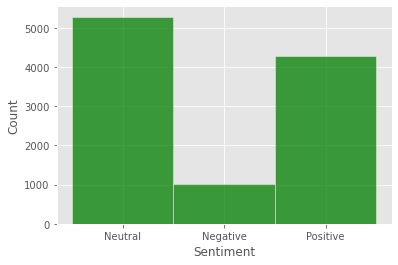

In [143]:
sns.histplot(data=df_text, x="Sentiment" , color = 'green') 

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

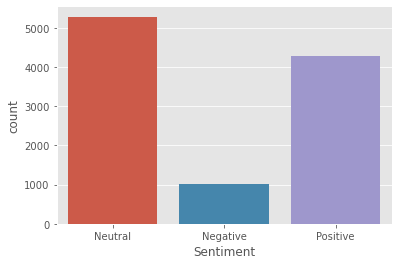

In [154]:
sns.color_palette("viridis", as_cmap=True)
a= sns.countplot(data=df_text, x="Sentiment" )
a

In [145]:
df_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10592 entries, 0 to 11019
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   text       10592 non-null  object 
 1   Polarity   10592 non-null  float64
 2   Sentiment  10592 non-null  object 
dtypes: float64(1), object(2)
memory usage: 589.0+ KB


In [146]:
df_text.head()

,text,Polarity,Sentiment
0,folks said daikon paste could treat cytokine s...,0.0,Neutral
1,world wrong side history year hopefully bigges...,-0.5,Negative
2,coronavirus sputnikv astrazeneca pfizerbiontec...,0.0,Neutral
3,facts immutable senator even youre ethically s...,0.1,Positive
4,explain need vaccine borisjohnson matthancock ...,0.0,Neutral


Text(0.5, 1.0, 'Distribution of sentiments')

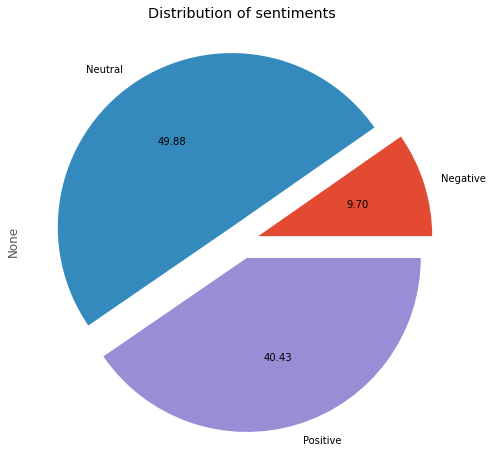

In [147]:
fig = plt.figure(figsize = (8,8))
explode = (0.1,0.1,0.1)
df_text.groupby('Sentiment').size().plot(kind='pie',explode = explode, autopct='%.2f')
plt.title('Distribution of sentiments')

In [148]:
pos_tweets = df_text[df_text['Sentiment']=='Positive']
pos_tweets

,text,Polarity,Sentiment
3,facts immutable senator even youre ethically s...,0.100000,Positive
5,anyone useful adviceguidance whether covid vac...,0.400000,Positive
7,many bright days 2020 best 1 bidenharris winni...,0.675000,Positive
10,deaths closing 300000 mark millions people wai...,0.250000,Positive
11,cnnbrk covid19 covidvaccine vaccine corona pfi...,1.000000,Positive
...,...,...,...
11004,schoolaged children likely test positive child...,0.051948,Positive
11006,usðÿºðÿ 10 children aged 511 got first shot la...,0.062500,Positive
11008,fully vaccinated ðÿðÿðÿ thank magsingal health...,0.200000,Positive
11012,yes children ages 5â11 years receive onethird ...,0.100000,Positive


In [149]:
w = df_text.loc[df_text['Sentiment'] == 'Positive']
w

,text,Polarity,Sentiment
3,facts immutable senator even youre ethically s...,0.100000,Positive
5,anyone useful adviceguidance whether covid vac...,0.400000,Positive
7,many bright days 2020 best 1 bidenharris winni...,0.675000,Positive
10,deaths closing 300000 mark millions people wai...,0.250000,Positive
11,cnnbrk covid19 covidvaccine vaccine corona pfi...,1.000000,Positive
...,...,...,...
11004,schoolaged children likely test positive child...,0.051948,Positive
11006,usðÿºðÿ 10 children aged 511 got first shot la...,0.062500,Positive
11008,fully vaccinated ðÿðÿðÿ thank magsingal health...,0.200000,Positive
11012,yes children ages 5â11 years receive onethird ...,0.100000,Positive


In [150]:
m = df_text[['Sentiment']]
m

,Sentiment
0,Neutral
1,Negative
2,Neutral
3,Positive
4,Neutral
...,...
11014,Neutral
11015,Neutral
11017,Neutral
11018,Negative


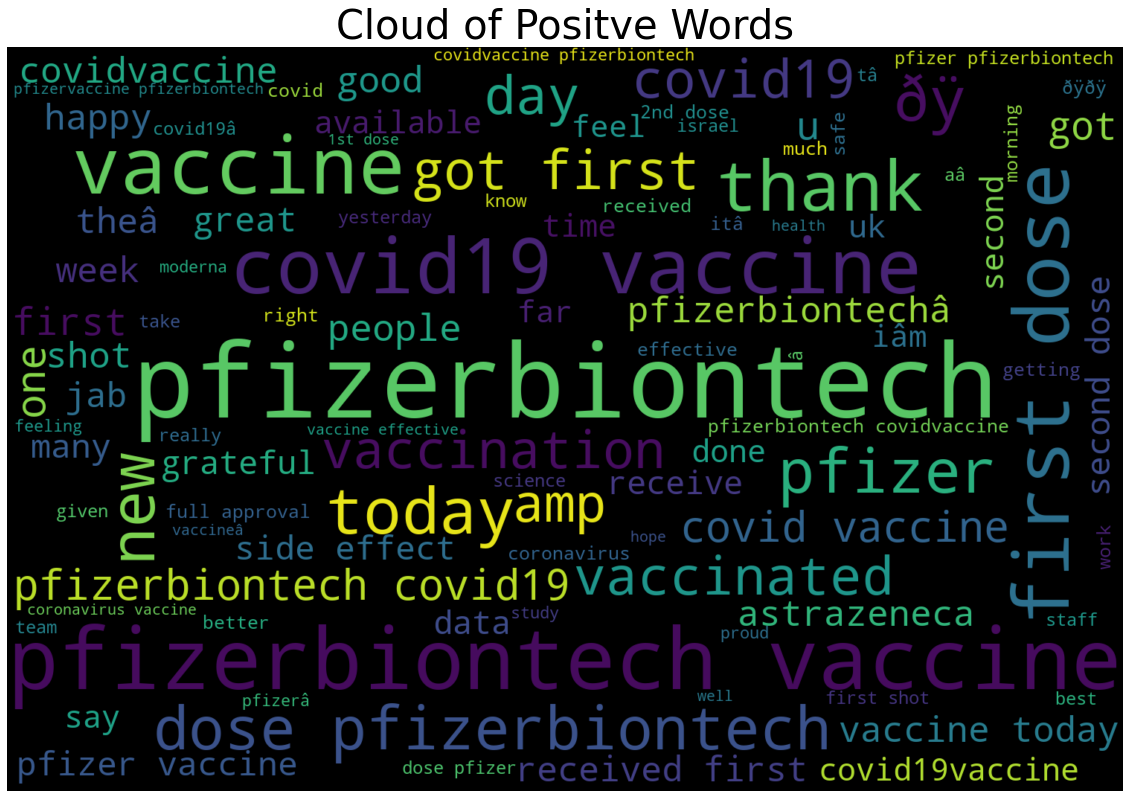

In [164]:

text = " ".join(i for i in pos_tweets.text)
wordcloud = WordCloud(background_color="black", max_words=100 , width = 1500,
               height = 1000).generate(text)
plt.figure( figsize=(20,15) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Cloud of Positve Words', fontsize = 40)

plt.axis("off")
plt.show()